# Binary Classification with PyTorch

## 1. Make classification data and get it ready

In [75]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [76]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({ "X1" : X[:,0], "X2" : X[:, 1], "label" : y })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


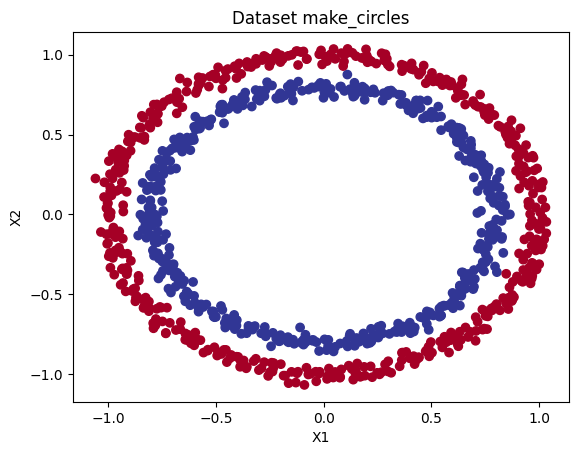

In [77]:
# Visualize the data
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Dataset make_circles")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

Note: the data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### Check input and output shapes

In [78]:
X.shape, y.shape

((1000, 2), (1000,))

In [79]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and y: {y_sample.shape}")
#

Values for one sample of X: [0.75424625 0.23148074] and y: 1
Shapes for one sample of X: (2,) and y: ()


### Turn data into tensors and create train and test splits

In [80]:
import torch
torch.__version__

'2.6.0+cu124'

In [81]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [82]:
# Print the first 5 values
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [83]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [84]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a Loss Function and an Optimizer
4. Create a training and test loop

In [85]:
# Import nn
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we'll create a model that:
1. Subclasses `nn.Module`
2. Creates 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model
4. Instantiate an instance of our model class and send it to the target device

In [86]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layers and outputs a single feature

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2

In [87]:
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [88]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5), nn.Linear(in_features=5, out_features=1)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [89]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
untrained_preds[:10]

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])


tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

### Setup a loss function and an optimizer

For binary classification problems we will use Binary Cross Entropy loss function.
For multi-class classification we will use Cross Entropy Loss.
For optimizers, two of the most common are SGD and Adam, however PyTorch has many built-in options.

In [90]:
# Setup the loss function
# loss_fn = nn.BCELoss() requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # Combines Sigmoid activation + BCELoss in a stable way

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

In [91]:
# Calculate accuracy : out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Train the model

We need to setup the following loop:
1. Forward pass
2. Calculate the loss
3. Zero gradients
4. Perform backpropagation on the loss
5. Step the optimizer (perform gradient descent)

### Going from raw logits -> prediction probabilites -> prediction labels

Our model outputs are going to be raw logits.

We can convert these logits into prediction probabilities by passing them to some kind of activation function (sigmoid for binary classification, softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them (binary classification) or taking the `argmax()` (multi-class classification).

In [92]:
# View the first 5 outputs of the forward pass on the dast data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [93]:
# Use the sigmoid activation function on our logits to find the prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [94]:
# Round the prediction probabilities in order to obtain the prediction labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

y_pred_labels

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)

### Building a training and testing loop

In [95]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) # Because BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Zero Gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

In [96]:
# Testing
model_0.eval()
with torch.inference_mode():
  # 1. Forward pass
  test_logits = model_0(X_test).squeeze()
  test_pred = torch.round(torch.sigmoid(test_logits))

  # 2. Calculate test loss/acc
  test_loss = loss_fn(test_logits, y_test)
  test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happening


## Make predictions and evaluate the model

To do so, we're going to import a function called `plot_decision_boundaries()`

In [97]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download...


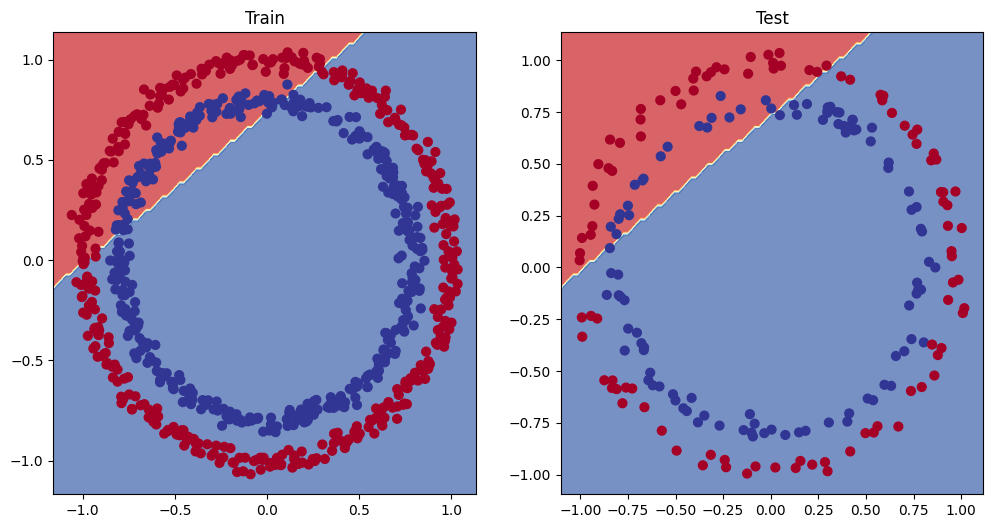

In [98]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we can change, they are referred to as **hyperparameters**.

In [99]:
# Create a new model

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [100]:
# Create an instance of the new model and assign it to the target device
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [101]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Creat an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001)

In [102]:
# Create a training loop for model_1
torch.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step optimizer (gradient descent)
  optimizer.step()

In [103]:
### Testing
model_1.eval()
with torch.inference_mode():
  test_logits = model_1(X_test).squeeze()
  test_pred = torch.round(torch.sigmoid(test_logits))

  test_loss = loss_fn(test_logits, y_test)
  test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

print(f"Test loss: {test_loss}, Test acc: {test_acc}")

Test loss: 0.6926921606063843, Test acc: 50.0


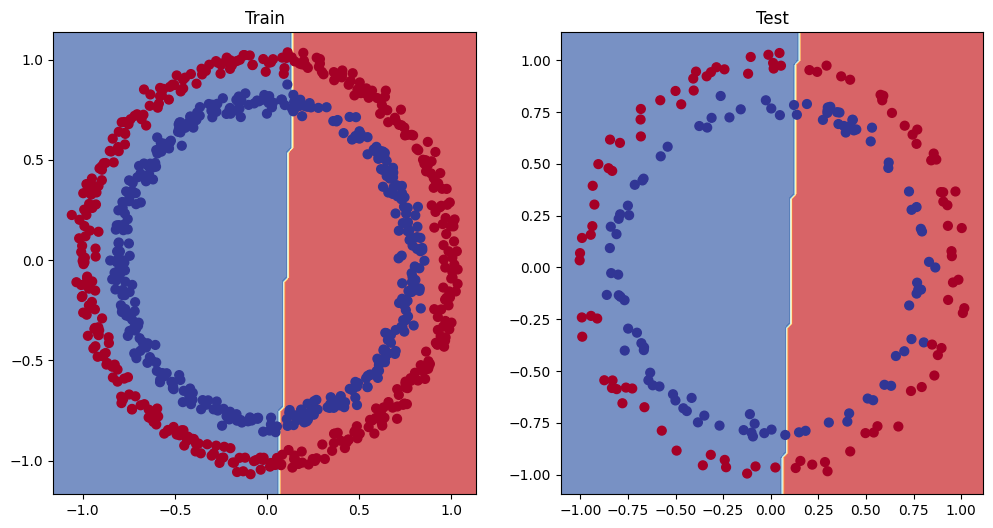

In [104]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out to a smaller problem.

In [105]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula

# Check the data
X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [106]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

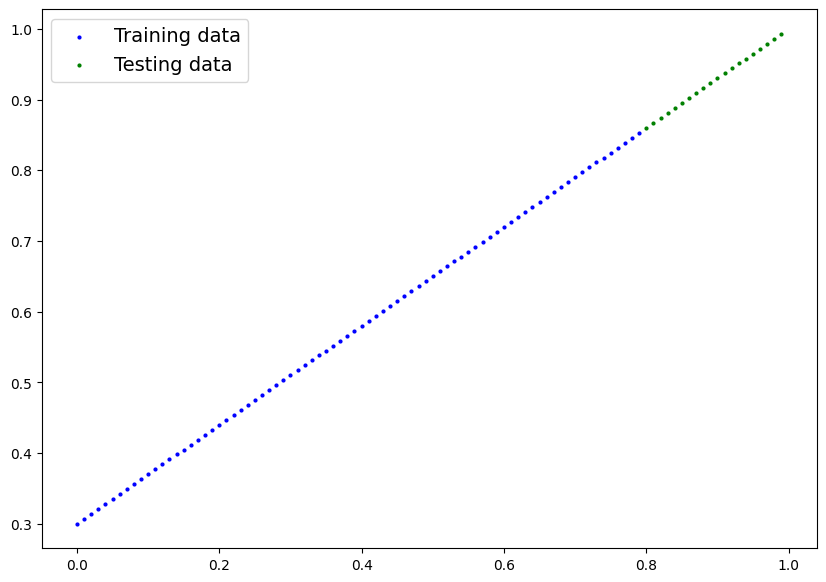

In [107]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

### Adjusting `model_1` to fit a straight line

In [108]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(nn.Linear(in_features=1, out_features=10), nn.Linear(in_features=10, out_features=10), nn.Linear(in_features=10, out_features=1)).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [109]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001)

In [110]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ### Training
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [111]:
# Test
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)
  test_loss = loss_fn(y_preds, y_test_regression)

print(f"Test loss: {test_loss}")

Test loss: 0.004707515239715576


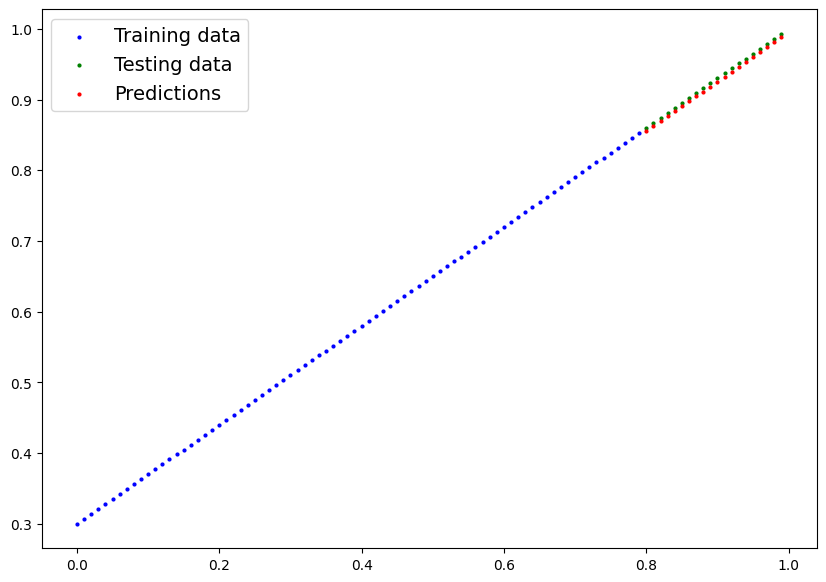

In [112]:
# Plot predictions
plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(), test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu(), predictions=y_preds.cpu())

So our model is good for predicting linear data, but it's not good for classifying data with a non-linear relation.

## The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) amount of linear and non-linear functions?

### Recreating non-lineare data (red and blue circles)

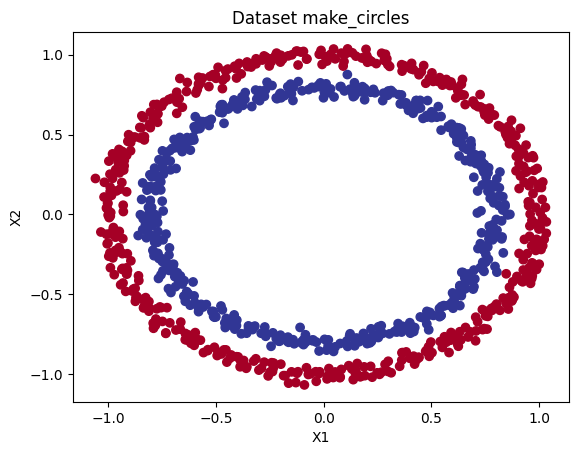

In [113]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

plt.scatter(X[:, 0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Dataset make_circles")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [114]:
# Convert data to tensors ant then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building a model with non-linearity

In [115]:
# Create the model
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() #ReLU activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [116]:
# Create an instance of the model
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [117]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### Training a model with non-linearity

In [118]:
torch.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 2000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step optimizer
  optimizer.step()

### Testing and evaluating the model with non-linearity

In [119]:
# Testing
model_3.eval()
with torch.inference_mode():
  test_logits = model_3(X_test).squeeze()
  test_pred = torch.round(torch.sigmoid(test_logits))

  test_loss = loss_fn(test_logits, y_test)
  test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  print(f"Test loss: {test_loss}, Test acc: {test_acc}")

Test loss: 0.06591331213712692, Test acc: 100.0


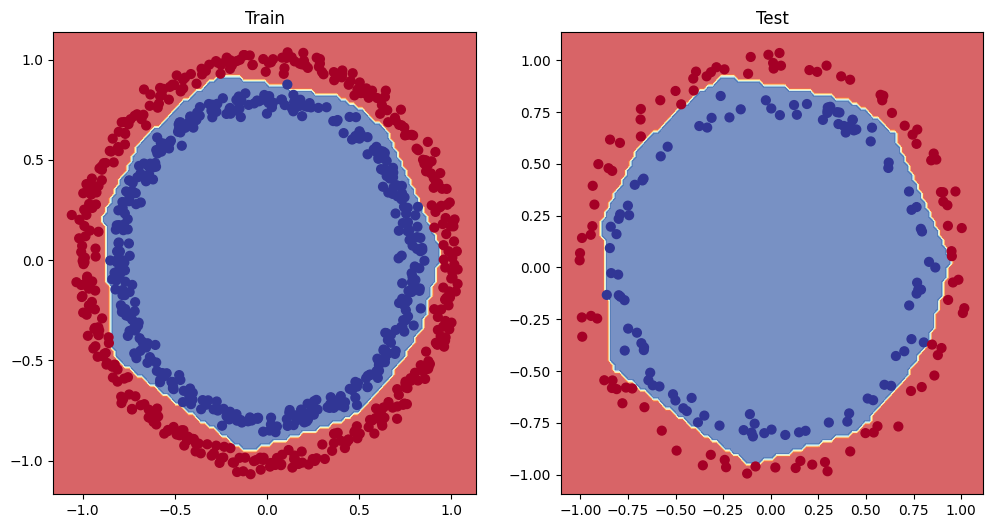

In [120]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

These tools are linear and non-linear functions.

In [121]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A.dtype

torch.float32

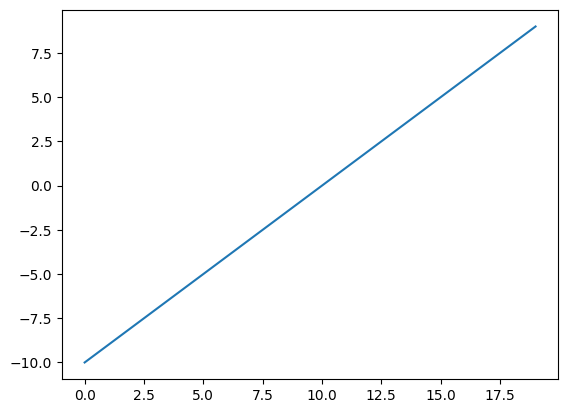

In [122]:
# Visualize the tensor
plt.plot(A)

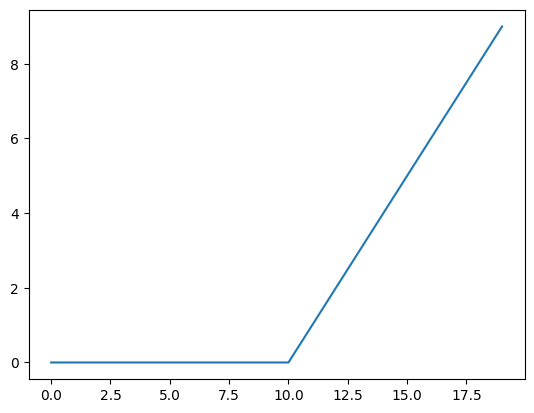

In [123]:
# Visualize the effect of ReLU
plt.plot(torch.relu(A))

In [124]:
# Replicate ReLU
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

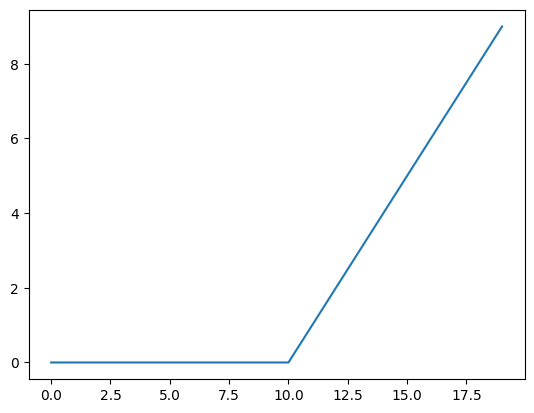

In [125]:
# Plot the result of applyint ReLU
plt.plot(relu(A))

In [126]:
# Let's now replicate the sigmoid
def sigmoid(x : torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

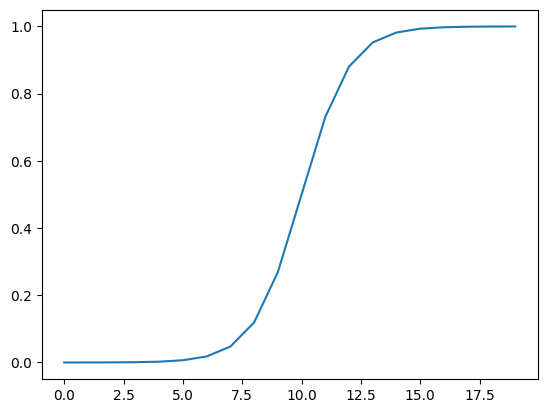

In [127]:
# Plot the result of applying Sigmoid
plt.plot(sigmoid(A))

# Multi-class classification with PyTorch

## Creating a toy multi-class dataset

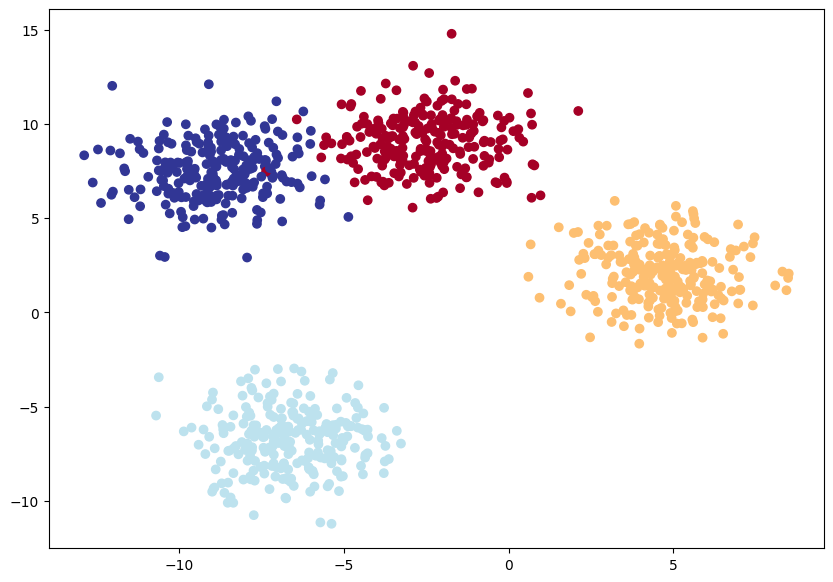

In [128]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # Instead of make_circles
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


## Building a multi-class classification model

In [129]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [130]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [131]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Create a loss function and an optimizer for a multi-class classification model

In [132]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### Getting predictions on test data before training

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits -> Pred probs -> Pred labels

In [133]:
# Get some raw outputs (logits) from the model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

# Convert logits into prediction probabilities using softmax function
y_pred_probs = torch.softmax(y_logits, dim=1)

# Get prediction labels from prediction probabilities
y_preds = y_pred_probs.argmax(dim=1)
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Creating a training loop for the model

In [134]:
torch.manual_seed(42)

# Put all data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device).type(torch.LongTensor)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device).type(torch.LongTensor)

# Loop through data
epochs = 2000

for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train)
  y_pred_probs = torch.softmax(y_logits, dim=1)
  y_pred = y_pred_probs.argmax(dim=1)

  # 2. Calculate loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step optimizer
  optimizer.step()

## Testing and evaluating the model

In [135]:
# Testing
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

# Convert logits into prediction probabilities using softmax function
y_pred_probs = torch.softmax(y_logits, dim=1)

# Get prediction labels from prediction probabilities
y_preds = y_pred_probs.argmax(dim=1)

test_loss = loss_fn(y_logits, y_blob_test.type(torch.LongTensor))
test_acc = accuracy_fn(y_true=y_blob_test.type(torch.LongTensor), y_pred=y_preds)

print(f"Test loss: {test_loss}, Test acc: {test_acc}")

Test loss: 0.009203226305544376, Test acc: 99.5


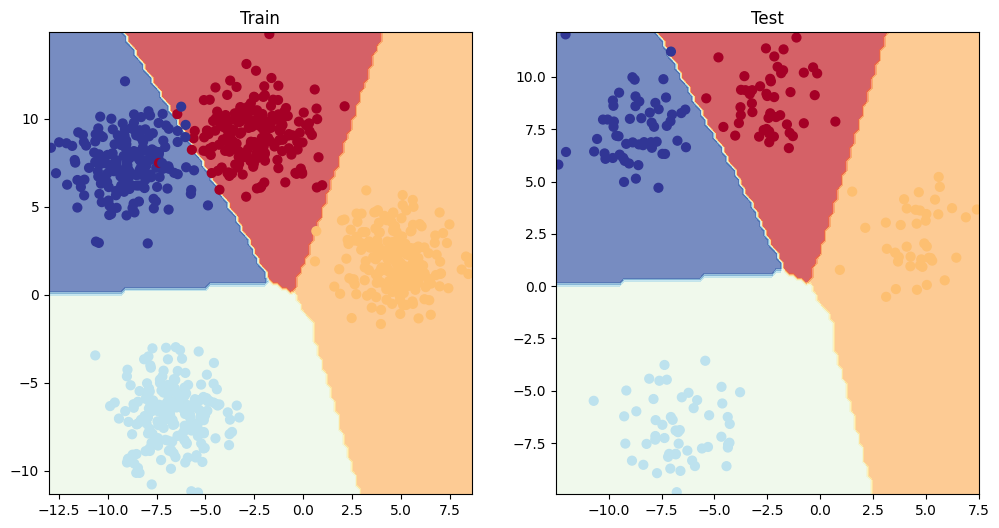

In [136]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## A few more classification metrics

* Accuracy - The ratio of correctly predicted instances to the total instances
* Precision - Of all the positive predictions, how many were actually correct
* Recall - Of all actial positive cases, how many did the model correctly identify
* F1-score - Harmonic mean of precision and recall
* Confusion matrix - a table showing actual vs. predicted classifications
* Classification report - A summary report showing precision, recall, F1-score, and support (number of true instances) for each class
